In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
cols = ["G" , "C" , "B" , "A" , "Ia" , "Ib" , "Ic" , "Va" , "Vb" , "Vc"] 
# Ia" , "Ib" , "Ic" , "Va" , "Vb" , "Vc is Input : features
# G , C , B , A is OutPut : labels
df = pd.read_csv("../../classData.csv")
cols[4:]
# Step 1: Encode fault combinations into single-class labels
fault_map = {
    '0000': 0,  # No Fault
    '1001': 1,  # LG
    '0011': 2,  # LL
    '0110': 3 , # LL
    '1011': 4,  # LLG
    '0111': 5,  # LLL
    '1111': 6   # LLLG
}
df

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


In [4]:
df['fault_type'] = df[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)
# Map to single class label
df['fault_class'] = df['fault_type'].map(fault_map)
# Drop rows with unknown fault combinations


In [6]:
df 


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,fault_type,fault_class
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001,1
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001,1
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001,1
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001,1
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0000,0
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0000,0
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0000,0
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0000,0


In [7]:
train , valid , test = np.split(df.sample(frac = 1) , [int(0.6 * len(df)) , int(0.8 * len(df))])
# train  60% |||||||||||||
# valid  20%  1234567890
# test 20%
test

c:\Users\OussamaTab\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,fault_type,fault_class
5569,0,0,0,0,39.702957,-29.301219,-5.640204,0.552612,-0.063832,-0.488780,0000,0
5007,1,1,1,1,877.928786,-352.528431,-525.402619,0.023748,-0.042200,0.018452,1111,6
4084,0,1,1,1,-840.584538,655.048450,187.561818,-0.007264,0.039791,-0.032527,0111,5
7442,0,0,0,0,-70.418950,53.194970,14.238906,-0.038754,-0.492640,0.531394,0000,0
7631,0,0,0,0,55.647086,-0.981697,-57.596733,0.117461,0.465833,-0.583294,0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
791,1,0,0,1,-662.409780,-70.772699,31.410239,0.292641,-0.214903,-0.077738,1001,1
1369,1,0,1,1,871.418680,-416.915981,16.229124,0.021658,-0.305774,0.284116,1011,4
1851,1,0,1,1,200.522931,640.315534,57.782565,0.041029,-0.296401,0.255372,1011,4
862,1,0,0,1,-808.725393,-29.751114,-21.035731,-0.092796,0.414212,-0.321416,1001,1


In [ ]:
def scale_dataset(dataFrame):
    from tensorflow.keras.utils import to_categorical
    x = dataFrame[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']].values
    # Get the fault class values from the dataFrame parameter (not the global df)
    y = dataFrame['fault_class'].values
    
    # Scale the input features
    scaler = StandardScaler() 
    x = scaler.fit_transform(x)

    # One-hot encode the target for categorical classification
    y_cat = to_categorical(y, num_classes=7)
    
    return x, y_cat  # Return the one-hot encoded y values

In [9]:
# Re-run these steps with the fixed function
X_train, Y_train = scale_dataset(train)
X_valid, Y_valid = scale_dataset(valid)
X_test, Y_test = scale_dataset(test)

X_train

array([[-0.15689576,  1.7381391 , -1.90088961, -0.12083297, -0.04469607,
         0.15999231],
       [-0.04851574, -1.40184489,  1.70491342, -1.31259608, -0.04315334,
         1.2818696 ],
       [-1.92877003,  0.95737225,  1.24606453, -0.04684902,  0.15166518,
        -0.1122098 ],
       ...,
       [-0.10843628,  0.09060731, -0.01294838,  1.65692895, -1.70353491,
         0.19444939],
       [ 0.53524456,  0.0201497 ,  0.00808212,  1.23347009, -1.91421648,
         0.81086434],
       [ 1.75008403, -0.33331006, -0.03092681,  0.13751971, -1.10378401,
         1.00841535]])

In [15]:
# Define autoencoder structure
input_dim = X_train.shape[1]
input_dim

6

In [18]:
# Input layer
input_layer = Input(shape=(input_dim,))
input_layer

<KerasTensor shape=(None, 6), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>

In [19]:
# Encoder layers (compress)
encoded = Dense(4, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)
encoded

<KerasTensor shape=(None, 2), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>

In [20]:
# Decoder layers (reconstruct)
decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)
decoded

<KerasTensor shape=(None, 6), dtype=float32, sparse=False, ragged=False, name=keras_tensor_7>

In [22]:
# Build and compile model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder

<Functional name=functional_1, built=True>

In [24]:
# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9958 - val_loss: 0.9594
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9359 - val_loss: 0.8959
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8709 - val_loss: 0.8345
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8056 - val_loss: 0.7335
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6827 - val_loss: 0.6121
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5885 - val_loss: 0.5620
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5424 - val_loss: 0.5289
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5250 - val_loss: 0.5052
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4969 - val_loss: 0.4874
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4854 - val_loss: 0.4746
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4771 - val_loss: 0.4655
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

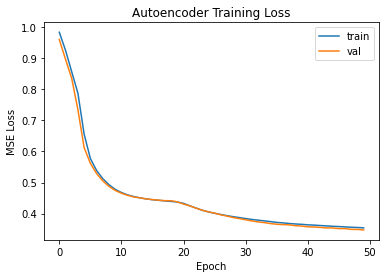

In [25]:
# Plot training loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.show()

In [43]:
from sklearn.metrics import classification_report

# Autoencoder predictions
X_pred = autoencoder.predict(X_train)

# Reconstruction error
mse = np.mean(np.power(X_train - X_pred, 2), axis=1)

# Threshold to classify anomalies
threshold = np.percentile(mse, 40)


y_pred = (mse > threshold).astype(int)

# Convert one-hot Y_train to class labels
y_labels = np.argmax(Y_train, axis=1)

# Now binary labels: 0 for normal, 1 for fault
y_true = (y_labels != 0).astype(int)

# Show classification metrics
print(classification_report(y_true, y_pred, target_names=['Normal', 'Fault']))

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

      Normal       0.13      0.18      0.15      1393
       Fault       0.60      0.51      0.55      3323

    accuracy                           0.41      4716
   macro avg       0.36      0.34      0.35      4716
weighted avg       0.46      0.41      0.43      4716



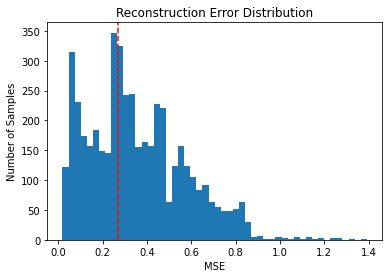

In [44]:
import matplotlib.pyplot as plt
plt.hist(mse, bins=50)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Number of Samples")
plt.show()


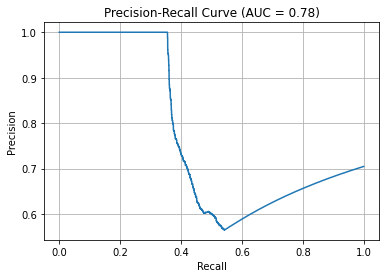

In [45]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_true, mse)
pr_auc = auc(recall, precision)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.grid()
plt.show()
